In [ ]:
import re
import math
import glob 
import chardet
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec

path = './finance_data/'

In [ ]:
all_files = glob.glob(path + 'moex-IMOEX-*-marg-optionsdesk.csv')

In [ ]:
with open(path + "moex-IMOEX-120325-marg-optionsdesk.csv", "rb") as f:
    result_encoding = chardet.detect(f.read())
    print(result_encoding["encoding"])

In [ ]:
dfs = []

for filename in all_files:
    date_match = re.search(r'IMOEX-(\d{6})', filename)
    
    if date_match:
        date_str = date_match.group(1)
        
        #convertion date to format dd.mm.yyyy
        day = date_str[:2]
        month = date_str[2:4]
        year = '20' + date_str[4:6]
        
        formatted_date = f"{day}.{month}.{year}"
        
        df_start = pd.read_csv(filename, encoding = 'windows-1251')
        
        df_start['execution_date'] = formatted_date
        dfs.append(df_start)
        print(f"Processed {filename} with date {formatted_date}")


In [ ]:
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    
    combined_df['execution_date_dt'] = pd.to_datetime(combined_df['execution_date'], format='%d.%m.%Y')
    
    combined_df = combined_df.sort_values('execution_date_dt')
    
    combined_df.to_csv('combined_moex_options.csv', encoding='utf-8', index=False)
    
    print(f"Combined {len(dfs)} files into 'combined_moex_options.csv'")
    print(f"Shape of combined dataframe: {combined_df.shape}")
    
    # to verify if needed
    # print(combined_df.head())
else:
    print("No matching files found.")

In [ ]:
for filename in all_files:
    df_start = pd.read_csv(filename, encoding='windows-1251')
    
    for col in df_start.select_dtypes(include=[object]):
        df_start[col] = df_start[col].astype(str).str.encode('windows-1251', errors='ignore').str.decode('utf-8')
    
    dfs.append(df_start)

In [ ]:
df_combined = pd.read_csv('combined_moex_options.csv', encoding='utf-8')

# for i, col in enumerate(df_combined.columns):
#     print(f"{i}: {col}")

In [ ]:
#clean corrupted columns
corrupted_cols = [col for col in df_combined.columns if '�' in str(col) or 'пїЅ' in str(col) or '???' in str(col)]
df_combined = df_combined.drop(columns=corrupted_cols)
df_combined = df_combined.drop(columns=['Unnamed: 22', 'execution_date'])

df_combined.head(20)

In [ ]:
with open("combined_moex_options.csv", "rb") as f:
    result_en = chardet.detect(f.read())
    print(f"Detected encoding after saving: {result_en['encoding']}")

In [ ]:
#clean missing columns
missing_percentage = df_combined.isna().mean() * 100

for col, pct in missing_percentage.items():
    print(f"{col}: {pct:.2f}%")

trg_vl_miss = 96.5
columns_to_drop = missing_percentage[missing_percentage >= trg_vl_miss].index.tolist()

print(f"\nDropping {len(columns_to_drop)} columns with {trg_vl_miss}% or more missing values")

df_cleaned = df_combined.drop(columns=columns_to_drop)

df_cleaned.to_csv('cleaned_moex_options.csv', encoding='utf-8', index=False)

print(f"Original DataFrame shape: {df_combined.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

In [ ]:
df_cleaned.head(10)

In [ ]:
# математическое ожидание и стандартное отклонение для Расчтенной цены Call опциона
call_Settlement_price = 'CALL: Расчетная цена'
date_ex = 'execution_date_dt'
math_expectation = df_cleaned[call_Settlement_price].mean()
std_deviation = df_cleaned[call_Settlement_price].std()
print(call_Settlement_price)
print(f"Математическое ожидание цены: {math_expectation:.2f}")
print(f"Стандартное отклонение цены (волатильность): {std_deviation:.2f}")

In [ ]:
# математическое ожидание и стандартное отклонение для Расчтенной цены Call опциона
put_Settlement_price = 'PUT: Расчетная цена'
date_ex = 'execution_date_dt'
math_expectation = df_cleaned[put_Settlement_price].mean()
std_deviation = df_cleaned[put_Settlement_price].std()
print(put_Settlement_price)
print(f"Математическое ожидание цены: {math_expectation:.2f}")
print(f"Стандартное отклонение цены (волатильность): {std_deviation:.2f}")

In [ ]:
# Простейшая стратегия:
# Если цена ниже математического ожидания, считаем это сигналом для покупки ("Покупка").
# Если цена выше математического ожидания, сигнал для продажи ("Продажа").
def generate_signal(price):
    if price < math_expectation:
        return 'Покупка'
    elif price > math_expectation:
        return 'Продажа'
    else:
        return 'Нейтрально'
signal_call = 'Сигнал Call'
signal_put = 'Сигнал Put'    
df_cleaned[signal_call] = df_cleaned[call_Settlement_price].apply(generate_signal)
df_cleaned[signal_put] = df_cleaned[put_Settlement_price].apply(generate_signal)

df_cleaned.head(50)

output_file = 'signals_data.csv'
df_cleaned.to_csv(output_file, index=False)
print(f"Данные с сигналами сохранены в файл: {output_file}")

In [ ]:
#working with cleaned doata, creating new copy

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

df = pd.read_csv('cleaned_moex_options.csv')

df['execution_date_dt'] = pd.to_datetime(df['execution_date_dt'])

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

df.head()


In [ ]:

expiry_dates = sorted(df['execution_date_dt'].unique())
print(f"Available expiration dates: {', '.join([str(date.date()) for date in expiry_dates[:5]])}...")

nearest_dates = expiry_dates[:3]
print(f"Focusing on nearest expiration dates: {', '.join([str(date.date()) for date in nearest_dates])}")

strikes = sorted(df['СТРАЙК'].dropna().unique())
print(f"Strike price range: {min(strikes)} to {max(strikes)}")
print(f"Number of available strikes: {len(strikes)}")

near_term_options = df[df['execution_date_dt'].isin(nearest_dates)]
print(f"Number of near-term options: {len(near_term_options)}")

In [ ]:
# Опционы с доступными ценами put & call
option_pairs = near_term_options[
    near_term_options['CALL: Расчетная цена'].notna() & 
    near_term_options['PUT: Расчетная цена'].notna()
]

if len(option_pairs) < 5:
    print("Warning: Limited data for estimating current index level")
    avg_index_level = df['СТРАЙК'].dropna().median()
    print(f"Using median strike price as estimate: {avg_index_level:.2f}")
else:
    # простейший подход: S ≈ K + (C - P)
    option_pairs['implied_level'] = option_pairs['СТРАЙК'] + (
        option_pairs['CALL: Расчетная цена'] - option_pairs['PUT: Расчетная цена']
    )
    
    option_pairs['call_put_diff'] = abs(option_pairs['CALL: Расчетная цена'] - option_pairs['PUT: Расчетная цена'])
    option_pairs_sorted = option_pairs.sort_values('call_put_diff')
    
    implied_index_df = option_pairs_sorted.head(5)[['СТРАЙК', 'implied_level', 'CALL: Расчетная цена', 'PUT: Расчетная цена', 'call_put_diff']]
    avg_index_level = implied_index_df['implied_level'].mean()
    
    print(f"Estimated current index level: {avg_index_level:.2f}")
    implied_index_df

In [ ]:
def analyze_straddle_strategy(options_df, avg_index_level):
    """
    Analyze straddle strategy (long call + long put at the same strike)
    """
    print("\n=== STRADDLE STRATEGIES (LONG CALL + LONG PUT) ===")
    # print("Хорошо подходит для ожидания большого движения в любом направлении")
    
    results = []
    
    try:
        straddles = options_df[
            options_df['CALL: ПРОДАЖА'].notna() & 
            options_df['PUT: ПРОДАЖА'].notna() &
            abs(options_df['СТРАЙК'] - avg_index_level) < 200  # Reasonably close to ATM
        ].copy()  # Create explicit copy
        
        if straddles.empty:
            print("No suitable options found for straddle strategy")
            return results
        
        for _, row in straddles.iterrows():
            call_cost = row['CALL: ПРОДАЖА']
            put_cost = row['PUT: ПРОДАЖА']
            
            # Check for NaN values
            if pd.isna(call_cost) or pd.isna(put_cost):
                continue
                
            total_cost = call_cost + put_cost
            
            if total_cost <= 0:
                continue
                
            break_even_up = row['СТРАЙК'] + total_cost
            break_even_down = row['СТРАЙК'] - total_cost
            
            pct_move_up = ((break_even_up - avg_index_level) / avg_index_level * 100)
            pct_move_down = ((avg_index_level - break_even_down) / avg_index_level * 100)
            
            contract_size = 100
            contracts = int(1_000_000 / (total_cost * contract_size))
            if contracts < 1:
                contracts = 1  # Min 1 contr
            total_investment = total_cost * contracts * contract_size
            
            result = {
                'date': row['execution_date_dt'],
                'strategy': 'Straddle',
                'strike': row['СТРАЙК'],
                'call_cost': call_cost,
                'put_cost': put_cost,
                'total_cost': total_cost,
                'break_even_up': break_even_up,
                'break_even_down': break_even_down,
                'pct_move_up': pct_move_up,
                'pct_move_down': pct_move_down,
                'contracts': contracts,
                'investment': total_investment,
                'max_loss': total_investment,
                'iv': row['IV'] if pd.notnull(row['IV']) else None
            }
            
            results.append(result)
            
            print(f"Expiry: {row['execution_date_dt'].date()}, Strike: {row['СТРАЙК']}, Total Cost: {total_cost:.2f}")
            print(f"  Break-even Up: {break_even_up:.2f} ({pct_move_up:.2f}% move)")
            print(f"  Break-even Down: {break_even_down:.2f} ({pct_move_down:.2f}% move)")
            print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_investment:,.0f} rubles")
            print(f"  Max loss: {total_investment:,.0f} rubles (entire premium)")
            print()
        
        if results:
            results = sorted(results, key=lambda x: (x['date'], abs(x['strike'] - avg_index_level)))
    
    except Exception as e:
        print(f"Error in straddle analysis: {e}")
    
    return results

def analyze_strangle_strategy(options_df, avg_index_level, nearest_dates):
    """
    Analyze strangle strategy (long OTM call + long OTM put)
    """
    print("\n=== STRANGLE STRATEGIES (LONG OTM CALL + LONG OTM PUT) ===")
    print("Cheaper than straddle but requires a bigger move")
    
    results = []
    
    try:
        call_options = options_df[
            (options_df['CALL: ПРОДАЖА'].notna()) & 
            (options_df['СТРАЙК'] > avg_index_level)
        ].sort_values('СТРАЙК')
        
        put_options = options_df[
            (options_df['PUT: ПРОДАЖА'].notna()) & 
            (options_df['СТРАЙК'] < avg_index_level)
        ].sort_values('СТРАЙК', ascending=False)
        
        if call_options.empty or put_options.empty:
            print("Not enough data for strangle strategy - need both OTM calls and puts")
            return results
        
        for date in nearest_dates:
            try:
                date_calls = call_options[call_options['execution_date_dt'] == date].copy()
                date_puts = put_options[put_options['execution_date_dt'] == date].copy()
                
                if date_calls.empty or date_puts.empty:
                    continue
                
                target_call_strike = avg_index_level * 1.05
                target_put_strike = avg_index_level * 0.95
                
                if len(date_calls) > 0 and len(date_puts) > 0:
                    date_calls['strike_diff'] = abs(date_calls['СТРАЙК'] - target_call_strike)
                    date_puts['strike_diff'] = abs(date_puts['СТРАЙК'] - target_put_strike)
                    
                    best_call_idx = date_calls['strike_diff'].idxmin()
                    best_put_idx = date_puts['strike_diff'].idxmin()
                    
                    best_call = date_calls.loc[best_call_idx]
                    best_put = date_puts.loc[best_put_idx]
                    
                    call_cost = best_call['CALL: ПРОДАЖА']
                    put_cost = best_put['PUT: ПРОДАЖА']
                    
                    if pd.isna(call_cost) or pd.isna(put_cost) or call_cost <= 0 or put_cost <= 0:
                        print(f"  Skipping date {date.date()} due to invalid cost values")
                        continue
                    
                    total_cost = call_cost + put_cost
                    
                    break_even_up = best_call['СТРАЙК'] + total_cost
                    break_even_down = best_put['СТРАЙК'] - total_cost
                    
                    pct_move_up = ((break_even_up - avg_index_level) / avg_index_level * 100)
                    pct_move_down = ((avg_index_level - break_even_down) / avg_index_level * 100)
                    
                    contract_size = 100
                    contracts = int(1_000_000 / (total_cost * contract_size))
                    if contracts < 1:
                        contracts = 1  # Minimum 1 contract
                    total_investment = total_cost * contracts * contract_size
                    
                    result = {
                        'date': date,
                        'strategy': 'Strangle',
                        'call_strike': best_call['СТРАЙК'],
                        'put_strike': best_put['СТРАЙК'],
                        'call_cost': call_cost,
                        'put_cost': put_cost,
                        'total_cost': total_cost,
                        'break_even_up': break_even_up,
                        'break_even_down': break_even_down,
                        'pct_move_up': pct_move_up,
                        'pct_move_down': pct_move_down,
                        'contracts': contracts,
                        'investment': total_investment,
                        'max_loss': total_investment
                    }
                    
                    results.append(result)
                    
                    print(f"Expiry: {date.date()}")
                    print(f"  Call Strike: {best_call['СТРАЙК']}, Put Strike: {best_put['СТРАЙК']}")
                    print(f"  Total Cost: {total_cost:.2f}")
                    print(f"  Break-even Up: {break_even_up:.2f} ({pct_move_up:.2f}% move)")
                    print(f"  Break-even Down: {break_even_down:.2f} ({pct_move_down:.2f}% move)")
                    print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_investment:,.0f} rubles")
                    print(f"  Max loss: {total_investment:,.0f} rubles (entire premium)")
                    print()
                
            except (KeyError, ValueError) as e:
                print(f"  Error analyzing strangle for date {date.date()}: {e}")
                continue
                
    except Exception as e:
        print(f"Error in strangle analysis: {e}")
    
    return results

def analyze_bear_put_spread(options_df, avg_index_level, nearest_dates):
    """
    Analyze bear put spread strategy for downside protection
    """
    print("\n=== BEAR PUT SPREAD STRATEGIES ===")
    print("Good for expecting downside movement with defined risk")
    
    results = []
    
    try:
        for date in nearest_dates:
            try:
                date_options = options_df[options_df['execution_date_dt'] == date]
                
                if date_options.empty:
                    continue
                
                atm_puts = date_options[
                    (date_options['PUT: ПРОДАЖА'].notna()) &
                    (abs(date_options['СТРАЙК'] - avg_index_level) < 100)
                ].copy()
                
                if atm_puts.empty:
                    continue
                
                atm_puts['strike_diff'] = abs(atm_puts['СТРАЙК'] - avg_index_level)
                atm_put_idx = atm_puts['strike_diff'].idxmin()
                atm_put = atm_puts.loc[atm_put_idx]
                
                target_otm_strike = avg_index_level * 0.9
                otm_puts = date_options[
                    (date_options['PUT: ПОКУПКА'].notna()) & 
                    (date_options['СТРАЙК'] < atm_put['СТРАЙК'])
                ].copy()
                
                if otm_puts.empty:
                    continue
                
                otm_puts['strike_diff'] = abs(otm_puts['СТРАЙК'] - target_otm_strike)
                otm_put_idx = otm_puts['strike_diff'].idxmin()
                otm_put = otm_puts.loc[otm_put_idx]
                
                buy_cost = atm_put['PUT: ПРОДАЖА']
                sell_credit = otm_put['PUT: ПОКУПКА']
                
                if pd.isna(buy_cost) or pd.isna(sell_credit):
                    print(f"  Skipping date {date.date()} due to NaN cost values")
                    continue
                    
                net_cost = buy_cost - sell_credit
                
                if net_cost <= 0:
                    print(f"  Skipping date {date.date()} due to non-positive net cost: {net_cost}")
                    continue
                
                max_profit = atm_put['СТРАЙК'] - otm_put['СТРАЙК'] - net_cost
                max_loss = net_cost
                break_even = atm_put['СТРАЙК'] - net_cost
                
                # Calculate ROI
                roi = (max_profit / net_cost * 100)
                pct_move = ((avg_index_level - break_even) / avg_index_level * 100)
                
                # Position sizing
                contract_size = 100
                contracts = int(1_000_000 / (net_cost * contract_size))
                if contracts < 1:
                    contracts = 1  # Minimum 1 contract
                total_cost = net_cost * contracts * contract_size
                total_max_profit = max_profit * contracts * contract_size
                
                result = {
                    'date': date,
                    'strategy': 'Bear Put Spread',
                    'buy_strike': atm_put['СТРАЙК'],
                    'sell_strike': otm_put['СТРАЙК'],
                    'buy_cost': buy_cost,
                    'sell_credit': sell_credit,
                    'net_cost': net_cost,
                    'max_profit': max_profit,
                    'max_loss': max_loss,
                    'break_even': break_even,
                    'roi': roi,
                    'pct_move': pct_move,
                    'contracts': contracts,
                    'total_cost': total_cost,
                    'total_max_profit': total_max_profit
                }
                
                results.append(result)
                
                print(f"Expiry: {date.date()}")
                print(f"  Buy Put @ {atm_put['СТРАЙК']}, Sell Put @ {otm_put['СТРАЙК']}")
                print(f"  Net Cost: {net_cost:.2f}, Max Profit: {max_profit:.2f}")
                print(f"  Break-even: {break_even:.2f} ({pct_move:.2f}% move), ROI: {roi:.2f}%")
                print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_cost:,.0f} rubles")
                print(f"  Max profit: {total_max_profit:,.0f} rubles")
                print(f"  Max loss: {total_cost:,.0f} rubles")
                print()
                
            except (KeyError, ValueError) as e:
                print(f"  Error analyzing bear put spread for date {date.date()}: {e}")
                continue
                
    except Exception as e:
        print(f"Error in bear put spread analysis: {e}")
    
    return results

def analyze_bull_call_spread(options_df, avg_index_level, nearest_dates):
    """
    Analyze bull call spread strategy (buy ATM/near-ATM call, sell OTM call)
    """
    print("\n=== BULL CALL SPREAD STRATEGIES ===")
    print("Good for expecting moderate upside movement with defined risk")
    
    results = []
    
    try:
        for date in nearest_dates:
            try:
                date_options = options_df[options_df['execution_date_dt'] == date]
                
                if date_options.empty:
                    continue
                
                # Find near-ATM calls to buy
                atm_calls = date_options[
                    (date_options['CALL: ПРОДАЖА'].notna()) &
                    (abs(date_options['СТРАЙК'] - avg_index_level) < 100)
                ].copy()
                
                if atm_calls.empty:
                    continue
                
                atm_calls['strike_diff'] = abs(atm_calls['СТРАЙК'] - avg_index_level)
                atm_call_idx = atm_calls['strike_diff'].idxmin()
                atm_call = atm_calls.loc[atm_call_idx]
                
                # Find OTM calls to sell (around 5% higher than current level)
                target_otm_strike = avg_index_level * 1.05
                otm_calls = date_options[
                    (date_options['CALL: ПОКУПКА'].notna()) & 
                    (date_options['СТРАЙК'] > atm_call['СТРАЙК'])
                ].copy()
                
                if otm_calls.empty:
                    continue
                
                otm_calls['strike_diff'] = abs(otm_calls['СТРАЙК'] - target_otm_strike)
                otm_call_idx = otm_calls['strike_diff'].idxmin()
                otm_call = otm_calls.loc[otm_call_idx]
                
                # Calculate costs and profits
                buy_cost = atm_call['CALL: ПРОДАЖА']
                sell_credit = otm_call['CALL: ПОКУПКА']
                
                if pd.isna(buy_cost) or pd.isna(sell_credit):
                    print(f"  Skipping date {date.date()} due to NaN cost values")
                    continue
                    
                net_cost = buy_cost - sell_credit
                
                if net_cost <= 0:
                    print(f"  Skipping date {date.date()} due to non-positive net cost: {net_cost}")
                    continue
                
                max_profit = otm_call['СТРАЙК'] - atm_call['СТРАЙК'] - net_cost
                max_loss = net_cost
                break_even = atm_call['СТРАЙК'] + net_cost
                
                # Calculate ROI and required price move
                roi = (max_profit / net_cost * 100)
                pct_move = ((break_even - avg_index_level) / avg_index_level * 100)
                
                # Position sizing
                contract_size = 100
                contracts = int(1_000_000 / (net_cost * contract_size))
                if contracts < 1:
                    contracts = 1  # Minimum 1 contract
                total_cost = net_cost * contracts * contract_size
                total_max_profit = max_profit * contracts * contract_size
                
                result = {
                    'date': date,
                    'strategy': 'Bull Call Spread',
                    'buy_strike': atm_call['СТРАЙК'],
                    'sell_strike': otm_call['СТРАЙК'],
                    'buy_cost': buy_cost,
                    'sell_credit': sell_credit,
                    'net_cost': net_cost,
                    'max_profit': max_profit,
                    'max_loss': max_loss,
                    'break_even': break_even,
                    'roi': roi,
                    'pct_move': pct_move,
                    'contracts': contracts,
                    'total_cost': total_cost,
                    'total_max_profit': total_max_profit
                }
                
                results.append(result)
                
                print(f"Expiry: {date.date()}")
                print(f"  Buy Call @ {atm_call['СТРАЙК']}, Sell Call @ {otm_call['СТРАЙК']}")
                print(f"  Net Cost: {net_cost:.2f}, Max Profit: {max_profit:.2f}")
                print(f"  Break-even: {break_even:.2f} ({pct_move:.2f}% move), ROI: {roi:.2f}%")
                print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_cost:,.0f} rubles")
                print(f"  Max profit: {total_max_profit:,.0f} rubles")
                print(f"  Max loss: {total_cost:,.0f} rubles")
                print()
                
            except (KeyError, ValueError) as e:
                print(f"  Error analyzing bull call spread for date {date.date()}: {e}")
                continue
                
    except Exception as e:
        print(f"Error in bull call spread analysis: {e}")
    
    return results

def analyze_directional_strategies(options_df, avg_index_level):
    """
    Analyze simple directional strategies (long call and long put)
    """
    long_call_results = []
    long_put_results = []
    
    # 1. LONG CALL
    print("\n=== LONG CALL STRATEGY ===")
    print("Simple directional bet on market rising")
    
    try:
        long_calls = options_df[
            (options_df['CALL: ПРОДАЖА'].notna()) &
            (abs(options_df['СТРАЙК'] - avg_index_level) < 200)  # Near ATM
        ].copy()  # Create explicit copy
        
        if long_calls.empty:
            print("No suitable options found for long call strategy")
        else:
            # Add calculated fields
            long_calls['break_even'] = long_calls['СТРАЙК'] + long_calls['CALL: ПРОДАЖА']
            long_calls['pct_move'] = ((long_calls['break_even'] - avg_index_level) / avg_index_level * 100)
            
            # Sort by expiration date and distance from ATM
            long_calls['strike_diff'] = abs(long_calls['СТРАЙК'] - avg_index_level)
            long_calls = long_calls.sort_values(['execution_date_dt', 'strike_diff']).head(3)
            
            for _, row in long_calls.iterrows():
                cost = row['CALL: ПРОДАЖА']
                
                # Check for NaN or non-positive values
                if pd.isna(cost) or cost <= 0:
                    continue
                    
                break_even = row['break_even']
                pct_move = row['pct_move']
                
                # Position sizing
                contract_size = 100
                contracts = int(1_000_000 / (cost * contract_size))
                if contracts < 1:
                    contracts = 1  # Minimum 1 contract
                total_cost = cost * contracts * contract_size
                
                result = {
                    'date': row['execution_date_dt'],
                    'strategy': 'Long Call',
                    'strike': row['СТРАЙК'],
                    'cost': cost,
                    'break_even': break_even,
                    'pct_move': pct_move,
                    'contracts': contracts,
                    'total_cost': total_cost,
                    'iv': row['IV'] if pd.notnull(row['IV']) else None
                }
                
                long_call_results.append(result)
                
                print(f"Expiry: {row['execution_date_dt'].date()}, Strike: {row['СТРАЙК']}, Cost: {cost:.2f}")
                print(f"  Break-even: {break_even:.2f} ({pct_move:.2f}% move)")
                print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_cost:,.0f} rubles")
                print(f"  Max loss: {total_cost:,.0f} rubles (entire premium)")
                print()
    except Exception as e:
        print(f"Error analyzing long call strategy: {e}")
    
    # 2. LONG PUT
    print("\n=== LONG PUT STRATEGY ===")
    print("Simple directional bet on market falling")
    
    try:
        long_puts = options_df[
            (options_df['PUT: ПРОДАЖА'].notna()) &
            (abs(options_df['СТРАЙК'] - avg_index_level) < 200) 
        ].copy() 
        
        if long_puts.empty:
            print("No suitable options found for long put strategy")
        else:
    
            long_puts['break_even'] = long_puts['СТРАЙК'] - long_puts['PUT: ПРОДАЖА']
            long_puts['pct_move'] = ((avg_index_level - long_puts['break_even']) / avg_index_level * 100)
            
            # Sort by expiration date and distance from ATM
            long_puts['strike_diff'] = abs(long_puts['СТРАЙК'] - avg_index_level)
            long_puts = long_puts.sort_values(['execution_date_dt', 'strike_diff']).head(3)
            
            for _, row in long_puts.iterrows():
                cost = row['PUT: ПРОДАЖА']
                
                if pd.isna(cost) or cost <= 0:
                    continue
                    
                break_even = row['break_even']
                pct_move = row['pct_move']
                
                contract_size = 100
                contracts = int(1_000_000 / (cost * contract_size))
                if contracts < 1:
                    contracts = 1 
                total_cost = cost * contracts * contract_size
                
                result = {
                    'date': row['execution_date_dt'],
                    'strategy': 'Long Put',
                    'strike': row['СТРАЙК'],
                    'cost': cost,
                    'break_even': break_even,
                    'pct_move': pct_move,
                    'contracts': contracts,
                    'total_cost': total_cost,
                    'iv': row['IV'] if pd.notnull(row['IV']) else None
                }
                
                long_put_results.append(result)
                
                print(f"Expiry: {row['execution_date_dt'].date()}, Strike: {row['СТРАЙК']}, Cost: {cost:.2f}")
                print(f"  Break-even: {break_even:.2f} ({pct_move:.2f}% move)")
                print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_cost:,.0f} rubles")
                print(f"  Max loss: {total_cost:,.0f} rubles (entire premium)")
                print()
    except Exception as e:
        print(f"Error analyzing long put strategy: {e}")
    
    return long_call_results, long_put_results

def assess_market_impact(df, strategy_results):
    """
    Assess market impact of our position
    """
    print("\n=== MARKET IMPACT ASSESSMENT ===")
    try:
        open_interest_data = df[(df['CALL: Открыт.позиций'].notna()) | (df['PUT: Открыт. позиций'].notna())]
        
        if open_interest_data.empty:
            print("No open interest data available for impact assessment")
            return
        
        call_oi = open_interest_data['CALL: Открыт.позиций'].dropna()
        put_oi = open_interest_data['PUT: Открыт. позиций'].dropna()
        
        if not call_oi.empty:
            avg_call_oi = call_oi.mean()
            max_call_oi = call_oi.max()
            print(f"Call options: Avg open interest {avg_call_oi:.2f}, Max: {max_call_oi}")
        
        if not put_oi.empty:
            avg_put_oi = put_oi.mean()
            max_put_oi = put_oi.max()
            print(f"Put options: Avg open interest {avg_put_oi:.2f}, Max: {max_put_oi}")
        
        typical_contracts = []
        
        if 'straddles' in strategy_results and strategy_results['straddles']:
            typical_contracts.append(strategy_results['straddles'][0]['contracts'])
            
        if 'strangles' in strategy_results and strategy_results['strangles']:
            typical_contracts.append(strategy_results['strangles'][0]['contracts'])
            
        if 'bear_put_spreads' in strategy_results and strategy_results['bear_put_spreads']:
            typical_contracts.append(strategy_results['bear_put_spreads'][0]['contracts'])
        
        if 'bull_call_spreads' in strategy_results and strategy_results['bull_call_spreads']:
            typical_contracts.append(strategy_results['bull_call_spreads'][0]['contracts'])  
            
        if 'long_calls' in strategy_results and strategy_results['long_calls']:
            typical_contracts.append(strategy_results['long_calls'][0]['contracts'])
            
        if 'long_puts' in strategy_results and strategy_results['long_puts']:
            typical_contracts.append(strategy_results['long_puts'][0]['contracts'])
        
        if typical_contracts:
            avg_contracts = sum(typical_contracts) / len(typical_contracts)
            print(f"With 1M rubles: Average number of contracts across strategies: ~{round(avg_contracts)}")
            
            if not call_oi.empty:
                market_impact_risk = (avg_contracts / avg_call_oi * 100)
                print(f"Market impact risk: Position would represent approximately {market_impact_risk:.2f}% of average open interest")
                
                if market_impact_risk > 10:
                    print("CAUTION: Your position may be large enough to impact market prices!")
                else:
                    print("Market impact risk appears to be manageable.")
        else:
            print("No strategy data available to assess market impact")
    except Exception as e:
        print(f"Error in market impact assessment: {e}")

def analyze_lognormal_distribution(df, avg_index_level):
    """
    Analyze lognormal distribution of option prices
    """
    print("\n=== LOGNORMAL DISTRIBUTION ANALYSIS ===")
    try:
        call_prices = df['CALL: Расчетная цена'].dropna()
        
        if call_prices.empty:
            print("No call price data available for lognormal analysis")
            return None, None, None, None
        
        q_low = call_prices.quantile(0.01)
        q_high = call_prices.quantile(0.99)
        call_prices_filtered = call_prices[(call_prices >= q_low) & (call_prices <= q_high)]
        
        mean = call_prices_filtered.mean()
        std_dev = call_prices_filtered.std()
        variance = std_dev ** 2
        
        # Check if mean is positive to avoid log of negative or zero
        if mean <= 0:
            print("Mean call price is zero or negative, cannot calculate lognormal distribution")
            return mean, std_dev, None, None
        
        # Parameters for lognormal distribution
        term = 1 + variance / (mean ** 2)
        if term <= 0:
            print("Invalid value for logarithm in lognormal distribution calculation")
            return mean, std_dev, None, None
            
        log_mean = np.log(mean) - 0.5 * np.log(term)
        log_sigma = np.sqrt(np.log(term))
        
        print(f"Mean call price: {mean:.2f}")
        print(f"Standard deviation: {std_dev:.2f}")
        print(f"Log-normal parameters: μ = {log_mean:.4f}, σ = {log_sigma:.4f}")
        
        up_move = avg_index_level * 1.1  # 10% up
        down_move = avg_index_level * 0.9  # 10% down
        

        if np.isfinite(log_mean) and np.isfinite(log_sigma) and log_sigma > 0:
            prob_up = 1 - stats.norm.cdf((np.log(up_move) - log_mean) / log_sigma)
            prob_down = stats.norm.cdf((np.log(down_move) - log_mean) / log_sigma)
            
            print(f"Estimated probability of >10% upside move: {prob_up * 100:.2f}%")
            print(f"Estimated probability of >10% downside move: {prob_down * 100:.2f}%")
        else:
            print("Cannot calculate move probabilities due to invalid distribution parameters")
            
        return mean, std_dev, log_mean, log_sigma
        
    except (ValueError, ZeroDivisionError) as e:
        print(f"Error calculating lognormal distribution: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Unexpected error in lognormal analysis: {e}")
        return None, None, None, None

In [ ]:
# Вывод по стратегиям

expiry_dates = sorted(df['execution_date_dt'].unique())

# nearest_dates = expiry_dates[:3]
nearest_dates = expiry_dates[:3]

print(f"Используются ближайшие даты истечения: {', '.join([str(date.date()) for date in nearest_dates])}")

near_term_options = df[df['execution_date_dt'].isin(nearest_dates)]
print(f"Количество доступных опционов с ближайшим сроком истечения: {len(near_term_options)}")

if near_term_options.empty:
    print("ВНИМАНИЕ: Опционы для ближайших дат истечения не найдены!")
else:
    straddle_results = analyze_straddle_strategy(near_term_options, avg_index_level)
    
    strangle_results = analyze_strangle_strategy(near_term_options, avg_index_level, nearest_dates)

    bear_put_results = analyze_bear_put_spread(near_term_options, avg_index_level, nearest_dates)
    
    bull_call_results = analyze_bull_call_spread(near_term_options, avg_index_level, nearest_dates)
    
    long_call_results, long_put_results = analyze_directional_strategies(near_term_options, avg_index_level)
    
    strategy_results = {
        'straddles': straddle_results,
        'strangles': strangle_results,
        'bear_put_spreads': bear_put_results,
        'bull_call_spreads': bull_call_results,
        'long_calls': long_call_results,
        'long_puts': long_put_results
    }
    
    assess_market_impact(df, strategy_results)
    
    mean, std_dev, log_mean, log_sigma = analyze_lognormal_distribution(df, avg_index_level)

In [ ]:
# График сравнения стратегий
def plot_strategy_comparison(strategy_results, avg_index_level):
    """
    Plot profit/loss diagrams for the recommended strategies
    """
    current_index = avg_index_level
    
    straddle = None
    if strategy_results['straddles']:
        straddle = next((s for s in strategy_results['straddles'] 
                          if abs(s['strike'] - 3200) < 10), 
                         strategy_results['straddles'][0])
    
    strangle = next(iter(strategy_results['strangles']), None)
    bear_put = next(iter(strategy_results['bear_put_spreads']), None)
    bull_call = next(iter(strategy_results['bull_call_spreads']), None) if 'bull_call_spreads' in strategy_results else None
    
    if not any([straddle, strangle, bear_put, bull_call]):
        print("No strategies are available for plotting")
        return
    
    min_index = np.floor(current_index * 0.8)
    max_index = np.ceil(current_index * 1.2)
    index_range = np.arange(min_index, max_index, 25)
    
    straddle_pl = []
    strangle_pl = []
    bear_put_pl = []
    bull_call_pl = []
    
    for i in index_range:
        # Straddle
        if straddle:
            if i > straddle['strike']:
                pl = ((i - straddle['strike']) * straddle['contracts'] * 100) - straddle['investment']
            else:
                pl = ((straddle['strike'] - i) * straddle['contracts'] * 100) - straddle['investment']
            straddle_pl.append(pl / 1000)  # Convert to thousands for better display
        
        # Strangle
        if strangle:
            if i > strangle['call_strike']:
                pl = ((i - strangle['call_strike']) * strangle['contracts'] * 100) - strangle['investment']
            elif i < strangle['put_strike']:
                pl = ((strangle['put_strike'] - i) * strangle['contracts'] * 100) - strangle['investment']
            else:
                pl = -strangle['investment']
            strangle_pl.append(pl / 1000)
        
        # Bear Put Spread
        if bear_put:
            if i >= bear_put['buy_strike']:
                pl = -bear_put['total_cost']
            elif i <= bear_put['sell_strike']:
                pl = bear_put['total_max_profit']
            else:
                pl = ((bear_put['buy_strike'] - i) * bear_put['contracts'] * 100) - bear_put['total_cost']
            bear_put_pl.append(pl / 1000)
            
        # Bull Call Spread
        if bull_call:
            if i <= bull_call['buy_strike']:
                pl = -bull_call['total_cost']
            elif i >= bull_call['sell_strike']:
                pl = bull_call['total_max_profit']
            else:
                pl = ((i - bull_call['buy_strike']) * bull_call['contracts'] * 100) - bull_call['total_cost']
            bull_call_pl.append(pl / 1000)
    
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2, height_ratios=[3, 1])
    plt.tight_layout(pad=3)
    
    # Main strategy comparison chart
    ax1 = fig.add_subplot(gs[0, :])
    if straddle:
        ax1.plot(index_range, straddle_pl, 'b-', linewidth=2, label=f"Long Straddle ({int(straddle['strike'])})")
    if strangle:
        ax1.plot(index_range, strangle_pl, 'g-', linewidth=2, label=f"Long Strangle ({int(strangle['call_strike'])}/{int(strangle['put_strike'])})")
    if bear_put:
        ax1.plot(index_range, bear_put_pl, 'r-', linewidth=2, label=f"Bear Put Spread ({int(bear_put['buy_strike'])}/{int(bear_put['sell_strike'])})")
    if bull_call:
        ax1.plot(index_range, bull_call_pl, 'orange', linewidth=2, label=f"Bull Call Spread ({int(bull_call['buy_strike'])}/{int(bull_call['sell_strike'])})")
    
    ax1.axhline(y=0, color='grey', linestyle='--', alpha=0.7) # horizontal line
    
    # Add vertical line at current index level
    ax1.axvline(x=current_index, color='purple', linestyle='-', alpha=0.5, label=f"Current Index (~{int(current_index)})")
    
    ax1.set_title('Сравнение прибылей и убытков для опционных стратегий (инвестиции 1 000 000 рублей)', fontsize=16)
    ax1.set_xlabel('Index Level', fontsize=14)
    ax1.set_ylabel('P/L (тыс. руб.)', fontsize=14)
    ax1.legend(loc='best', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Add break-even annotations
    if straddle:
        ax1.annotate(f"Straddle BE: {straddle['break_even_down']:.0f}",
                    xy=(straddle['break_even_down'], 0), xytext=(straddle['break_even_down'], -300),
                    arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10)
        ax1.annotate(f"Straddle BE: {straddle['break_even_up']:.0f}",
                    xy=(straddle['break_even_up'], 0), xytext=(straddle['break_even_up'], -300),
                    arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10)
    
    if strangle:
        ax1.annotate(f"Strangle BE: {strangle['break_even_down']:.0f}",
                    xy=(strangle['break_even_down'], 0), xytext=(strangle['break_even_down'], -500),
                    arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10)
        ax1.annotate(f"Strangle BE: {strangle['break_even_up']:.0f}",
                    xy=(strangle['break_even_up'], 0), xytext=(strangle['break_even_up'], -500),
                    arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10)
    
    if bear_put:
        ax1.annotate(f"Bear Put BE: {bear_put['break_even']:.0f}",
                    xy=(bear_put['break_even'], 0), xytext=(bear_put['break_even'], 300),
                    arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)
                    
    if bull_call:
        ax1.annotate(f"Bull Call BE: {bull_call['break_even']:.0f}",
                    xy=(bull_call['break_even'], 0), xytext=(bull_call['break_even'], 500),
                    arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=10)
    
    # Create strategy info lists for text boxes
    strat_info = []
    
    if straddle:
        strat_info.append({
            'title': 'Long Straddle',
            'color': 'blue',
            'data': [
                f"Информация: {straddle['contracts']} контрактов на страйке {straddle['strike']} ({straddle['date'].date()})",
                f"Стоимость: {straddle['investment']:,.0f} рублей",
                f"Безубыток: {straddle['break_even_up']:.0f} и {straddle['break_even_down']:.0f}",
                f"Стратегия: Ожидание значительного движения в любом направлении",
                f"   "
            ]
        })
        
    if strangle:
        strat_info.append({
            'title': 'Long Strangle',
            'color': 'green',
            'data': [
                f"Информация: {strangle['contracts']} контрактов на страйках {strangle['call_strike']}/{strangle['put_strike']} ({strangle['date'].date()})",
                f"Стоимость: {strangle['investment']:,.0f} рублей",
                f"Безубыток: {strangle['break_even_up']:.0f} и {strangle['break_even_down']:.0f}",
                f"Стратегия: Ожидание очень сильного движения в любом направлении"
            ]
        })
        
    if bear_put:
        strat_info.append({
            'title': 'Bear Put Spread',
            'color': 'red',
            'data': [
                f"Информация: {bear_put['contracts']} контрактов на страйках {bear_put['buy_strike']}/{bear_put['sell_strike']} ({bear_put['date'].date()})",
                f"Стоимость: {bear_put['total_cost']:,.0f} рублей",
                f"Безубыток: {bear_put['break_even']:.0f}, Максимальная прибыль: {bear_put['total_max_profit']:,.0f}",
                f"Стратегия: Ожидание снижения с ограниченным риском и доходностью"
            ]
        })
        
    if bull_call:
        strat_info.append({
            'title': 'Bull Call Spread',
            'color': 'orange',
            'data': [
                f"Информация: {bull_call['contracts']} контрактов на страйках {bull_call['buy_strike']}/{bull_call['sell_strike']} ({bull_call['date'].date()})",
                f"Стоимость: {bull_call['total_cost']:,.0f} рублей",
                f"Безубыток: {bull_call['break_even']:.0f}, Максимальная прибыль: {bull_call['total_max_profit']:,.0f}",
                f"Стратегия: Ожидание роста с ограниченным риском и доходностью"
            ]
        })

    # Create info text boxes
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    ax2.axis('off')
    ax3.axis('off')
    
    # Add strategy information text
    props = dict(boxstyle='round', alpha=0.1)
    strat_count = len(strat_info)
    
    # Distribute strategies between the two subplots
    left_count = (strat_count + 1) // 2  # Ceiling division
    
    for i, info in enumerate(strat_info):
        if i < left_count:
            # Left subplot
            y_offset = i * 0.25
            ax2.text(0.05, 0.9 - y_offset, info['title'], fontsize=14, color=info['color'], fontweight='bold')
            for j, line in enumerate(info['data']):
                ax2.text(0.05, 0.85 - y_offset - j*0.05, line, fontsize=12)
        else:
            # Right subplot
            y_offset = (i - left_count) * 0.25
            ax3.text(0.05, 0.9 - y_offset, info['title'], fontsize=14, color=info['color'], fontweight='bold')
            for j, line in enumerate(info['data']):
                ax3.text(0.05, 0.85 - y_offset - j*0.05, line, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_strategy_comparison(strategy_results, avg_index_level)

In [ ]:
def plot_lognormal_distribution(df, mean, std_dev, log_mean, log_sigma):
    """
    Построение логнормального распределения цен колл-опционов
    """
    call_prices = df['CALL: Расчетная цена'].dropna()
    
    if call_prices.empty:
        print("Нет доступных данных о ценах колл-опционов для логнормального анализа")
        return

    x = np.linspace(max(0.1, mean - 3*std_dev), mean + 3*std_dev, 1000)
    pdf_lognormal = stats.lognorm.pdf(x, s=log_sigma, scale=np.exp(log_mean))

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.hist(call_prices, bins=30, density=True, alpha=0.6, color='skyblue', label='Фактические цены колл-опционов')
    
    ax.plot(x, pdf_lognormal, 'r-', linewidth=2, label='Аппроксимированное логнормальное распределение')
    
    ax.axvline(x=mean, color='blue', linestyle='--', alpha=0.7, label=f'Средняя цена: {mean:.2f}')
    
    ax.axvline(x=mean + std_dev, color='green', linestyle='--', alpha=0.5, label=f'Среднее + 1σ: {mean+std_dev:.2f}')
    ax.axvline(x=mean - std_dev, color='green', linestyle='--', alpha=0.5, label=f'Среднее - 1σ: {max(0, mean-std_dev):.2f}')
    
    ax.set_title('Логнормальное распределение цен колл-опционов MOEX', fontsize=16)
    ax.set_xlabel('Цена колл-опциона', fontsize=14)
    ax.set_ylabel('Плотность вероятности', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_lognormal_distribution(df, mean, std_dev, log_mean, log_sigma)


In [ ]:
def generate_signals(df, call_Settlement_price, reference_value=None):
    """
    Generate buy/sell signals based on price comparison with a reference value.
    
    Parameters:
    - df: DataFrame containing the price data
    - call_Settlement_price: Column name for the price data
    - reference_value: Value to compare prices against (if None, uses mean price)
    
    Returns:
    - DataFrame with added 'Сигнал' (Signal) column
    """
    df_with_signals = df.copy()
    
    if reference_value is None:
        reference_value = df_with_signals[call_Settlement_price].mean()
        print(f"Using mean price as reference: {reference_value:.2f}")
    
    df_with_signals['Сигнал'] = 'Нейтрально' 
    
    df_with_signals.loc[df_with_signals[call_Settlement_price] < reference_value, 'Сигнал'] = 'Покупка'
    
    df_with_signals.loc[df_with_signals[call_Settlement_price] > reference_value, 'Сигнал'] = 'Продажа'
    
    buy_count = (df_with_signals['Сигнал'] == 'Покупка').sum()
    sell_count = (df_with_signals['Сигнал'] == 'Продажа').sum()
    neutral_count = (df_with_signals['Сигнал'] == 'Нейтрально').sum()
    
    print(f"Generated signals: {buy_count} Buy, {sell_count} Sell, {neutral_count} Neutral")
    
    return df_with_signals

date_ex = 'execution_date_dt' 
call_Settlement_price = 'CALL: Расчетная цена' 

df_with_signals = generate_signals(df, call_Settlement_price)

plt.plot(df_with_signals[date_ex], df_with_signals[call_Settlement_price], label=call_Settlement_price, color='blue')

buy_signals = df_with_signals[df_with_signals['Сигнал'] == 'Покупка']
plt.scatter(buy_signals[date_ex], buy_signals[call_Settlement_price], marker='^', color='green', label='Покупка', s=100)

sell_signals = df_with_signals[df_with_signals['Сигнал'] == 'Продажа']
plt.scatter(sell_signals[date_ex], sell_signals[call_Settlement_price], marker='v', color='red', label='Продажа', s=100)

plt.xlabel('Дата')
plt.ylabel(call_Settlement_price)
plt.title('Историческая цена и торговые сигналы')
plt.legend()
plt.show()


In [ ]:
def generate_signal_with_volatility(df, call_Settlement_price, type_signal):
    """
    Generate trading signals based on mathematical expectation and volatility.
    """
    df_with_signals = df.copy()
    
    math_expectation = df_with_signals[call_Settlement_price].mean()
    
    std_deviation = df_with_signals[call_Settlement_price].std()
    
    print(f"\nМатематическое ожидание цены: {math_expectation:.2f}")
    print(f"Стандартное отклонение цены (волатильность): {std_deviation:.2f}")
    
    df_with_signals['Сигнал'] = df_with_signals[call_Settlement_price].apply(
        lambda price: 'Покупка' if price < math_expectation else 
                      'Продажа' if price > math_expectation else 
                      'Нейтрально'
    )
    
    # Count signals
    buy_count = (df_with_signals['Сигнал'] == 'Покупка').sum()
    sell_count = (df_with_signals['Сигнал'] == 'Продажа').sum()
    
    print(f"Generated signals: {buy_count} Buy, {sell_count} Sell")
    
    return df_with_signals




Математическое ожидание цены: 602.33
Стандартное отклонение цены (волатильность): 481.29
Generated signals: 359 Buy, 278 Sell


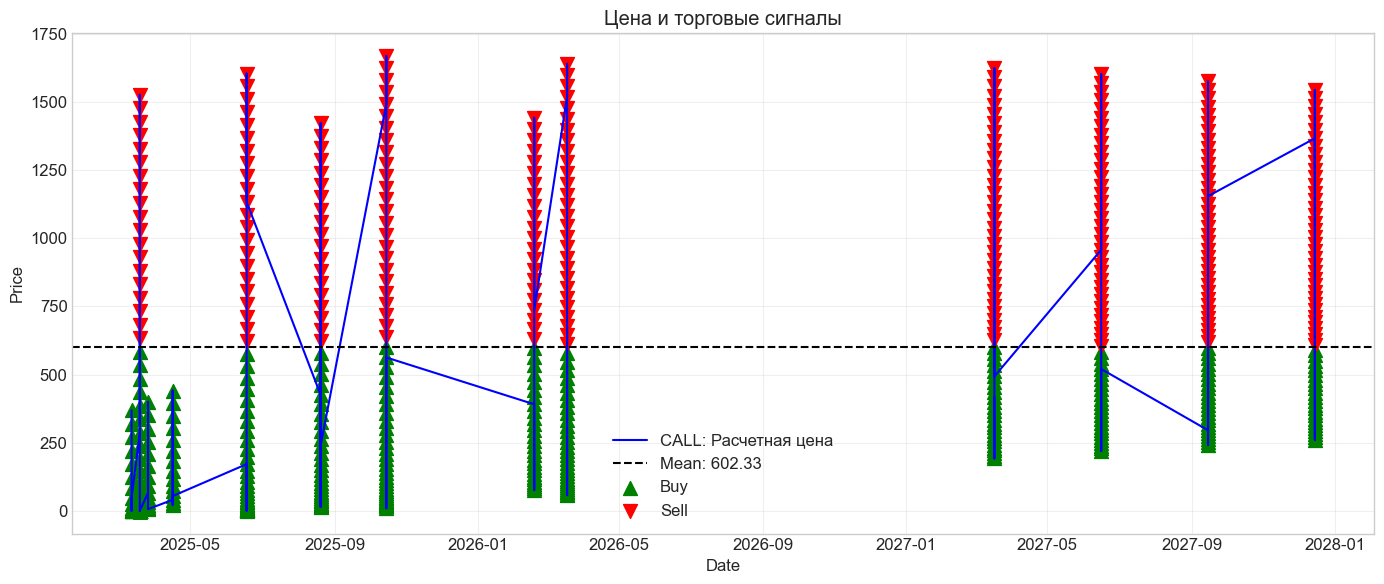

In [130]:

df_with_signals = generate_signal_with_volatility(df, call_Settlement_price)

plt.figure(figsize=(14, 6))

plt.plot(df_with_signals[date_ex], df_with_signals[call_Settlement_price], label=call_Settlement_price, color='blue')

mean_price = df_with_signals[call_Settlement_price].mean()
plt.axhline(y=mean_price, color='black', linestyle='--', label=f'Mean: {mean_price:.2f}')

buy_signals = df_with_signals[df_with_signals['Сигнал'] == 'Покупка']
plt.scatter(buy_signals[date_ex], buy_signals[call_Settlement_price], marker='^', color='green', label='Buy', s=100)

sell_signals = df_with_signals[df_with_signals['Сигнал'] == 'Продажа']
plt.scatter(sell_signals[date_ex], sell_signals[call_Settlement_price], marker='v', color='red', label='Sell', s=100)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Цена и торговые сигналы')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#Финальные рекомендации
print("\n=== FINAL RECOMMENDATION ===")
print("Based on the analysis, the following strategies are recommended:")

if strategy_results['bear_put_spreads']:
    best_bear_put = max(strategy_results['bear_put_spreads'], key=lambda x: x['roi'])
    print(f"\n1. BEAR PUT SPREAD (March {best_bear_put['date'].day}, 2025)")
    print(f"   Buy Put @ {best_bear_put['buy_strike']}, Sell Put @ {best_bear_put['sell_strike']}")
    print(f"   Cost: {best_bear_put['total_cost']:,.0f} rubles for {best_bear_put['contracts']} contracts")
    print(f"   Break-even: {best_bear_put['break_even']:.2f} ({best_bear_put['pct_move']:.2f}% move)")
    print(f"   Maximum profit: {best_bear_put['total_max_profit']:,.0f} rubles ({best_bear_put['roi']:.2f}% ROI)")
    print(f"   This strategy offers the best risk-reward ratio for expected downside movement.")
    
if strategy_results['bull_call_spreads']:
    best_bull_call = max(strategy_results['bull_call_spreads'], key=lambda x: x['roi'])
    print(f"\n2. BULL CALL SPREAD (March {best_bull_call['date'].day}, 2025)")
    print(f"   Buy Call @ {best_bull_call['buy_strike']}, Sell Call @ {best_bull_call['sell_strike']}")
    print(f"   Cost: {best_bull_call['total_cost']:,.0f} rubles for {best_bull_call['contracts']} contracts")
    print(f"   Break-even: {best_bull_call['break_even']:.2f} ({best_bull_call['pct_move']:.2f}% move)")
    print(f"   Maximum profit: {best_bull_call['total_max_profit']:,.0f} rubles ({best_bull_call['roi']:.2f}% ROI)")
    print(f"   This strategy offers the best risk-reward ratio for expected upside movement.")

if strategy_results['straddles']:
    best_straddle = min(strategy_results['straddles'], key=lambda x: min(x['pct_move_up'], x['pct_move_down']))
    print(f"\n2. LONG STRADDLE (March {best_straddle['date'].day}, 2025)")
    print(f"   Buy Call and Put @ {best_straddle['strike']} strike")
    print(f"   Cost: {best_straddle['investment']:,.0f} rubles for {best_straddle['contracts']} contracts")
    print(f"   Break-even Up: {best_straddle['break_even_up']:.2f} ({best_straddle['pct_move_up']:.2f}% move)")
    print(f"   Break-even Down: {best_straddle['break_even_down']:.2f} ({best_straddle['pct_move_down']:.2f}% move)")
    print(f"   This strategy provides unlimited profit potential in either direction with defined risk.")

if strategy_results['strangles']:
    best_strangle = max(strategy_results['strangles'], key=lambda x: x['contracts'])
    print(f"\n3. LONG STRANGLE (March {best_strangle['date'].day}, 2025)")
    print(f"   Buy OTM Call @ {best_strangle['call_strike']} and OTM Put @ {best_strangle['put_strike']}")
    print(f"   Cost: {best_strangle['investment']:,.0f} rubles for {best_strangle['contracts']} contracts")
    print(f"   Break-even Up: {best_strangle['break_even_up']:.2f} ({best_strangle['pct_move_up']:.2f}% move)")
    print(f"   Break-even Down: {best_strangle['break_even_down']:.2f} ({best_strangle['pct_move_down']:.2f}% move)")
    print(f"   This strategy offers maximum leverage for significant market moves.")

print("\n=== STRATEGY SUMMARY ===")
summary_data = []

if strategy_results['straddles']:
    summary_data.append({
        'Strategy': 'Long Straddle',
        'Strike(s)': f"{best_straddle['strike']}",
        'Break-even': f"{best_straddle['break_even_down']:.0f}/{best_straddle['break_even_up']:.0f}",
        'Contracts': best_straddle['contracts'],
        'Investment': f"{best_straddle['investment']:,.0f}",
        'Required Move': f"{min(best_straddle['pct_move_up'], best_straddle['pct_move_down']):.2f}%"
    })

if strategy_results['strangles']:
    summary_data.append({
        'Strategy': 'Long Strangle',
        'Strike(s)': f"{best_strangle['put_strike']}/{best_strangle['call_strike']}",
        'Break-even': f"{best_strangle['break_even_down']:.0f}/{best_strangle['break_even_up']:.0f}",
        'Contracts': best_strangle['contracts'],
        'Investment': f"{best_strangle['investment']:,.0f}",
        'Required Move': f"{min(best_strangle['pct_move_up'], best_strangle['pct_move_down']):.2f}%"
    })

if strategy_results['bear_put_spreads']:
    summary_data.append({
        'Strategy': 'Bear Put Spread',
        'Strike(s)': f"{best_bear_put['buy_strike']}/{best_bear_put['sell_strike']}",
        'Break-even': f"{best_bear_put['break_even']:.0f}",
        'Contracts': best_bear_put['contracts'],
        'Investment': f"{best_bear_put['total_cost']:,.0f}",
        'Required Move': f"{best_bear_put['pct_move']:.2f}%"
    })
    
if strategy_results['bull_call_spreads']:
    summary_data.append({
        'Strategy': 'Bull Call Spread',
        'Strike(s)': f"{best_bull_call['buy_strike']}/{best_bull_call['sell_strike']}",
        'Break-even': f"{best_bull_call['break_even']:.0f}",
        'Contracts': best_bull_call['contracts'],
        'Investment': f"{best_bull_call['total_cost']:,.0f}",
        'Required Move': f"{best_bull_call['pct_move']:.2f}%"
    })

pd.DataFrame(summary_data)